### Solving a Stokes equation on domains with different obstacles
We are given a domain $\Omega_\chi \subset \R^2$ which is defined as all points $x \in (0, 1)^2$ such that $\chi(x) = 1$. We will consider randomly placed circles removed from the domain $(0, 1)^2$. Our goal is to solve the following Stokes equation on $\Omega_\chi$:
\begin{align*}
-\mu \Delta u - \nabla p &= 0 &&\text{ in } \Omega_\chi, \\
\nabla \cdot u &= 0 &&\text{ in } \Omega_\chi.
\end{align*}
With the boundary conditions:
\begin{align*}
u &= u_{in} &&\text{ when } x_1 = 0, \\
(\mu \nabla u + p) \cdot n &= 0 &&\text{ when } x_1 = 1, \\
u &= 0 &&\text{ everywhere else on } \partial \Omega_\chi.
\end{align*}
Here, $u_{in}$ is a given inflow profile.

Our goal is to learn the solution operator that maps the domain $\Omega_\chi$ to the solution $u$.

In [ ]:
# This block is for GPU selection. Please execute.
import pathlib
import os
user = int(str(pathlib.Path().resolve())[22:24])
os.environ["CUDA_VISIBLE_DEVICES"]= str(user % 4)
import torch 
import torchphysics as tp
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np

Load data:

In [2]:
save_path = "/localdata/komso/datasets/FNO_data_Stokes"
input_data = torch.load(f"{save_path}/stokes_input.npy")
output_data = torch.load(f"{save_path}/stokes_output.npy")

print("Available data points:", len(input_data))
print("Shape of input data:", input_data.shape)
print("Shape of output data:", output_data.shape)

Available data points: 20000
Shape of input data: torch.Size([20000, 64, 64, 1])
Shape of output data: torch.Size([20000, 64, 64, 2])


Check example:

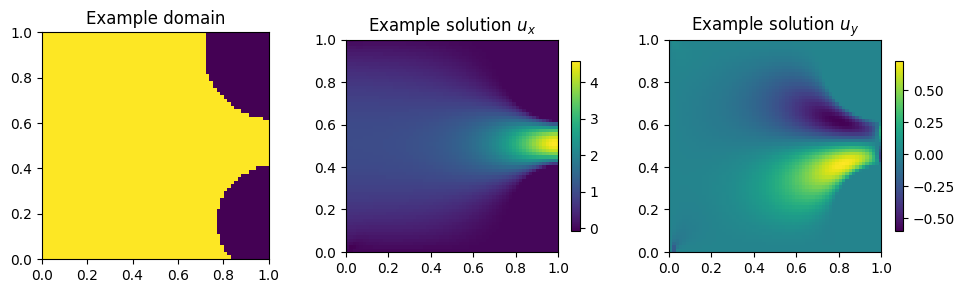

In [3]:
# Plot one example of the data
plot_idx = 0

f, axarr = plt.subplots(1, 3, figsize=(10, 3))
axarr[0].imshow(input_data[plot_idx, :, :, 0], origin='lower', extent=[0,1,0,1])
axarr[0].title.set_text(r"Example domain")
img = axarr[1].imshow(output_data[plot_idx, :, :, 0], origin='lower', extent=[0,1,0,1])
plt.colorbar(img, ax=axarr[1], shrink=0.75)
axarr[1].title.set_text(r"Example solution $u_x$")
img = axarr[2].imshow(output_data[plot_idx, :, :, 1], origin='lower', extent=[0,1,0,1])
axarr[2].title.set_text(r"Example solution $u_y$")
plt.colorbar(img, ax=axarr[2], shrink=0.75)
plt.tight_layout()

Define the spaces:

In [4]:
# TODO: Implement the spaces for X, chi and u.

X = tp.spaces.R2("x")
Chi = tp.spaces.R1("chi")
U = tp.spaces.R2("u")

fn_space_chi = tp.spaces.FunctionSpace(X, Chi)
fn_space_U = tp.spaces.FunctionSpace(X, U)

In [5]:
# Split data into training and testing:
total_data = len(input_data)
train_N = int(0.9*total_data)

train_in = input_data[:train_N]
train_out = output_data[:train_N]

test_in = input_data[train_N:]
test_out = output_data[train_N:]

# TODO: Define FunctionSet (DataSet)
data_functionset_input = tp.domains.DataFunctionSet(fn_space_chi, train_in)
data_functionset_output = tp.domains.DataFunctionSet(fn_space_U, train_out)

Sampling as always

In [6]:
functionsampler_input = tp.samplers.FunctionSamplerRandomUniform(500, data_functionset_input)
functionsampler_output = tp.samplers.FunctionSamplerCoupled(data_functionset_output, functionsampler_input)

Next, we create the FNO in TorchPhysics. This is quite straightforward. The most important parameters are the number of Fourier layers, the number of hidden channels, and the number of Fourier modes that should be kept in each direction.

In [7]:
# TODO: Set the hidden channels to 32, the fourier layers to 4 and the fourier modes to 8
model = tp.models.FNO(Chi, U, 
                      fourier_layers=4, 
                      hidden_channels=32, 
                      fourier_modes=(8, 8),
                      skip_connections=True)

The learning condition is the same as before:

In [8]:
data_condition = tp.conditions.OperatorCondition(module=model, 
                                                 input_function_sampler=functionsampler_input, 
                                                 output_function_sampler=functionsampler_output)

Now start the training. Given that the problem is a bit more complex, we have a few more parameters in the FNO, and multiple people train on the same GPU, the training is quite slow!
Hence we only train for a few iterations, and instead will load a pretrained model (trained with 100000 iterations) afterwards.

In [ ]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)
solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme
trainer = pl.Trainer(devices=1, accelerator="gpu",
                    num_sanity_val_steps=0,
                    benchmark=True,
                    max_steps=200, 
                    logger=False, 
                    callbacks=[RichProgressBar(theme=RichProgressBarTheme(metrics= "black", metrics_format='.7f'))], # show training process
                    enable_checkpointing=False)

trainer.fit(solver)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 168 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
168 K     Trainable params
0         Non-trainable params
168 K     Total params
0.673     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/pytorch_lightning/tra

Epoch 0: 100%|██████████| 200/200 [00:30<00:00,  6.63it/s, train/loss=0.0235]

`Trainer.fit` stopped: `max_steps=200` reached.


Epoch 0: 100%|██████████| 200/200 [00:30<00:00,  6.63it/s, train/loss=0.0235]


First we check the current results:

In [17]:
model_output = model(tp.spaces.Points(test_in, Chi)).as_tensor.detach().cpu()

rel_error = torch.norm(model_output - test_out, p=2, dim=(1,2,3))
rel_error /= torch.norm(test_out, p=2, dim=(1,2,3))

rel_error = torch.mean(torch.sqrt(rel_error))

print(f"Relative error in L^2: {rel_error*100} %")

Relative error in L^2: 17.18873405456543 %


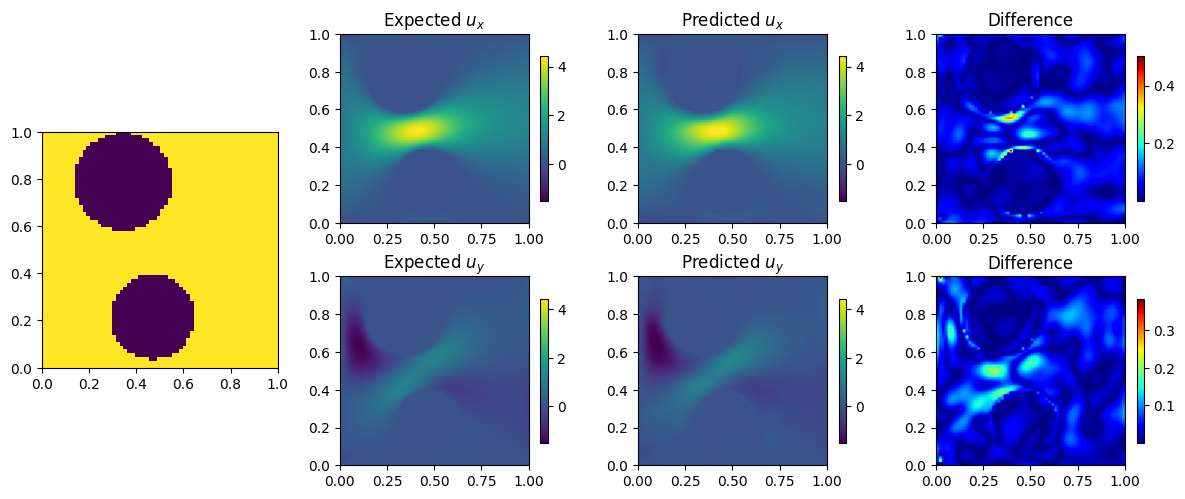

In [18]:
plot_idx = 12

sol_min = torch.min(test_out[plot_idx])
sol_max = torch.max(test_out[plot_idx])

# Plot 
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(2, 4)

test_in = test_in.cpu()
# First column: just plot the input
ax_big = fig.add_subplot(gs[:, 0]) 
ax_big.imshow(test_in[plot_idx, :, :, 0], origin='lower', extent=[0,1,0,1])
axarr[0].title.set_text(r"Example domain")


# Remaining subplots (2 rows x 3 columns)
plot_data = [test_out[plot_idx], 
             model_output[plot_idx], 
             torch.abs(test_out[plot_idx] - model_output[plot_idx])]
title = [[r"Expected $u_x$", r"Predicted $u_x$", r"Difference"], 
         [r"Expected $u_y$", r"Predicted $u_y$", r"Difference"]]
for r in range(2):
    for c in range(1, 4):
        ax = fig.add_subplot(gs[r, c])
        if c < 3:
            img = ax.imshow(plot_data[c-1][:, :, r], extent=[0,1,0,1],
                            vmin=sol_min, vmax=sol_max, origin='lower')
        else:
            img = ax.imshow(plot_data[c-1][:, :, r], extent=[0,1,0,1], cmap='jet', origin='lower')
        plt.colorbar(img, ax=ax, shrink=0.75)
        ax.set_title(title[r][c-1])

plt.tight_layout()

Now uncomment the next cell and run it. This will load the pretrained model, which should perfom better. To check this, just run the above cells again. 

Further fine-tuning and training could also improve the results more.

In [ ]:
#model.load(f"{save_path}/stokes_fno.pt")

Further we can ask ourself, how well does the FNO generalize to unseen obstacles. This we try in the next two cells. 
First we need to define our domain as a function/image $\chi$, where 1 equals that the point belongs to the domain and 0 that there is an obstacle.

The following cell implements a circle in the center of the domain. We observe that the solution looks reasonable, since such data was included in the training.

Try to use the provided code and create a square with cornes (0.3, 0.3), (0.7, 0.3), (0.7, 0.7) and (0.3, 0.7) as an obstacle:

In [13]:
test_chi = torch.ones((1, 64, 64, 1))

def pixel_coord_to_x_coord(i, j):
    return j/63.0, i/64.0

for i in range(64):
    for j in range(64):
        x, y = pixel_coord_to_x_coord(i, j)
        # TODO: implement square obstacle
        if abs(x-0.5) <= 0.2 and abs(y-0.5) <= 0.2:
            test_chi[0, i, j, 0] = 0.0
        #if (x-0.5)**2 + (y-0.5)**2 <= 0.01:
        #    test_chi[0, i, j, 0] = 0.0


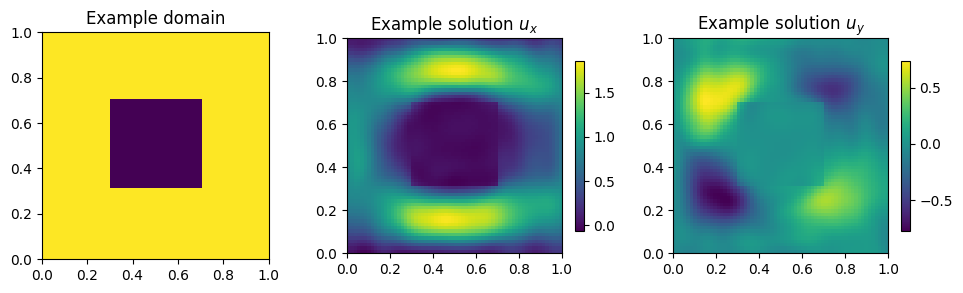

In [14]:
model_output = model(tp.spaces.Points(test_chi, Chi)).as_tensor.detach().cpu()

f, axarr = plt.subplots(1, 3, figsize=(10, 3))
axarr[0].imshow(test_chi[0, :, :, 0], origin='lower', extent=[0,1,0,1])
axarr[0].title.set_text(r"Example domain")
img = axarr[1].imshow(model_output[0, :, :, 0], origin='lower', extent=[0,1,0,1])
plt.colorbar(img, ax=axarr[1], shrink=0.75)
axarr[1].title.set_text(r"Example solution $u_x$")
img = axarr[2].imshow(model_output[0, :, :, 1], origin='lower', extent=[0,1,0,1])
axarr[2].title.set_text(r"Example solution $u_y$")
plt.colorbar(img, ax=axarr[2], shrink=0.75)
plt.tight_layout()